<a href="https://colab.research.google.com/github/Nik-Kras/ToMnet-N/blob/main/ToMnet%2BKeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
class CharNet(nnl.NeuralNetLayers):

For the single trajectory τi in the past episode, the
ToMnet forms the character embedding echar,i as follows. We
 (1) pre-process the data from each time-step by spatialising the actions,
 a(obs), concatenating these with the respective states, x(obs),
 (2) passing through a 5-layer resnet, with 32 channels, ReLU nonlinearities,
 and batch-norm, followed by average pooling.
 (3) We pass the results through an LSTM with 64 channels,
 with a linear output to either a 2-dim or 8-dim echar,i (no substantial difference in results).
@author: Chuang, Yun-Shiuan; Edwinn
"""

import tensorflow as tf
from tensorflow import keras

from keras.models import Model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.layers import BatchNormalization
from keras.layers import LSTM
from keras import activations

class CustomCnnCharNet(keras.layers.Layer):
  def __init__(self, input_tensor=None, activation="linear", filters=32):
        super(CustomCnnCharNet, self).__init__()
        if input_tensor is None:
          self.conv = tf.keras.layers.Conv2D(filters=filters,
                                  kernel_size=(3, 3),
                                  strides=(1, 1),
                                  activation=activation,
                                  padding="same")
        else:
          self.conv = tf.keras.layers.Conv2D(filters=filters,
                                  kernel_size=(3, 3),
                                  strides=(1, 1),
                                  activation=activation,
                                  padding="same",
                                  input_shape=input_tensor)
        self.conv_handler = tf.keras.layers.TimeDistributed(self.conv)

  def call(self, inputs):
    # print("CNN intput: ",inputs.shape)
    x = self.conv_handler(inputs)
    return x

class CustomCnnPredNet(keras.layers.Layer):
  def __init__(self, input_tensor=None, activation="linear", filters=32):
        super(CustomCnnPredNet, self).__init__()
        if input_tensor is None:
          self.conv = tf.keras.layers.Conv2D(filters=filters,
                                  kernel_size=(3, 3),
                                  strides=(1, 1),
                                  activation=activation,
                                  padding="same")
        else:
          self.conv = tf.keras.layers.Conv2D(filters=filters,
                                  kernel_size=(3, 3),
                                  strides=(1, 1),
                                  activation=activation,
                                  padding="same",
                                  input_shape=input_tensor)

  def call(self, inputs):
    # print("CNN intput: ",inputs.shape)
    x = self.conv(inputs)
    return x

class ResBlockCharNet(keras.layers.Layer):
  def __init__(self):
        super(ResBlockCharNet, self).__init__()
        self.conv1 = CustomCnnCharNet(activation="relu")
        # Use Batch Normalisation and then Relu activation in future!
        self.conv2 = CustomCnnCharNet(activation="linear")
        # Use Batch Normalisation in future!

  def call(self, inputs):
    x = self.conv1(inputs)
    x = self.conv2(x)
    x = tf.nn.relu(x + inputs)
    return x

class ResBlockPredNet(keras.layers.Layer):
  def __init__(self):
        super(ResBlockPredNet, self).__init__()
        self.conv1 = CustomCnnPredNet(activation="relu")
        # Use Batch Normalisation and then Relu activation in future!
        self.conv2 = CustomCnnPredNet(activation="linear")
        # Use Batch Normalisation in future!

  def call(self, inputs):
    x = self.conv1(inputs)
    x = self.conv2(x)
    x = tf.nn.relu(x + inputs)
    return x

class CustomLSTM(keras.layers.Layer):
  def __init__(self, num_hidden = 64, output_keep_prob = 0.2):
    super(CustomLSTM, self).__init__()
    self.lstm = LSTM(units=num_hidden,
                    activation = activations.tanh,
                    recurrent_activation = activations.sigmoid,
                    recurrent_dropout = output_keep_prob,
                    dropout = output_keep_prob)
    self.bn = BatchNormalization()

  def call(self, inputs):
    x = self.lstm(inputs)
    x = self.bn(x)
    return x

In [63]:
# --------------------------------------------------------------
# CharNet is a layer, as it doesn't have separate and own training,
# it is simply a part of whole network, so can be considered as a layer
# --------------------------------------------------------------
class CharNet(keras.layers.Layer):

    def __init__(self, input_tensor, n, N_echar):
        super(CharNet, self).__init__()

        # self.input_tensor = input_tensor
        self.n = n
        self.N_echar = N_echar

        self.conv = CustomCnnCharNet(input_tensor=input_tensor)
        self.res_blocks = [None] * n
        for i in range(n):
          self.res_blocks[i] = ResBlockCharNet()
        # Global Pool
        self.lstm = CustomLSTM()
        self.e_char = Dense(N_echar)
        

    def call(self, inputs):
        """
        Build the character net.
        """

        # input_tensor = self.input_tensor
        n = self.n
        N_echar = self.N_echar

        batch_size, trajectory_size, height, width, depth  = inputs.get_shape().as_list()

        # --------------------------------------------------------------
        # Paper codes
        # (16, 10, 12, 12, 11) -> (16, 10, 12, 12, 32)
        # Add initial Conv2D layer
        # Conv2D standard: Shape = (batch_size, width, height, channels)
        # Conv2D takes only width x height x channels (12, 12, 11)
        # Time Distributed layer feeds a Conv2D with time-frames (10 frames)
        # That process is happening in parallel for 16 objects in one batch
        # --------------------------------------------------------------
        x = self.conv(inputs)

        # --------------------------------------------------------------
        # Paper codes
        # (16, 10, 12, 12, 11) -> (16, 10, 12, 12, 32)
        # Add n residual layers
        # Conv2D takes only width x height x channels (12, 12, 11)
        # Time Distributed layer feeds a Conv2D with time-frames (10 frames)
        # That process is happening in parallel for 16 objects in one batch
        # --------------------------------------------------------------
        for i in range(n):
          x = self.res_blocks[i](x)    ### Possible error here!!!
            
        # --------------------------------------------------------------
        # Paper codes
        # (16, 10, 12, 12, 32) ->  (16, 10, 32)
        # Add average pooling
        # Collapse the spatial dimensions
        # --------------------------------------------------------------
        x = tf.reduce_mean(input_tensor=x, axis=[2, 3])

        # --------------------------------------------------------------
        # Paper codes
        # (16, 10, 32) ->  (16, 64)
        # Add LSTM
        # Standard: Shape = (batch_size, time_step, features)
        # for each x_i(t)(example_i's step_t): a (64, 1) = W(64, 32) * x (32, 1)
        # --------------------------------------------------------------
        x = self.lstm(x)

        # --------------------------------------------------------------
        # Paper codes
        # (16, 64) -> (16, 4)
        # Add Fully connected layer
        # (batch_size, features) - > (batch_size, e_char)
        # --------------------------------------------------------------
        x = self.e_char(x)

        return x


Testing CharNet:

In [71]:
c = CharNet((10, 12, 12, 11), 5, 8)

In [73]:
dummy_data_1 = tf.ones((16, 10, 12, 12, 11))
print(dummy_data_1.shape)

(16, 10, 12, 12, 11)


In [74]:
c.call(dummy_data_1)

<tf.Tensor: shape=(16, 8), dtype=float32, numpy=
array([[-0.1259548 ,  0.00561056, -0.01892414, -0.14196691, -0.04241611,
        -0.34323877,  0.23333062, -0.03937741],
       [-0.1259548 ,  0.00561056, -0.01892414, -0.14196691, -0.04241611,
        -0.34323877,  0.23333062, -0.03937741],
       [-0.1259548 ,  0.00561056, -0.01892414, -0.14196691, -0.04241611,
        -0.34323877,  0.23333062, -0.03937741],
       [-0.1259548 ,  0.00561056, -0.01892414, -0.14196691, -0.04241611,
        -0.34323877,  0.23333062, -0.03937741],
       [-0.1259548 ,  0.00561056, -0.01892414, -0.14196691, -0.04241611,
        -0.34323877,  0.23333062, -0.03937741],
       [-0.1259548 ,  0.00561056, -0.01892414, -0.14196691, -0.04241611,
        -0.34323877,  0.23333062, -0.03937741],
       [-0.1259548 ,  0.00561056, -0.01892414, -0.14196691, -0.04241611,
        -0.34323877,  0.23333062, -0.03937741],
       [-0.1259548 ,  0.00561056, -0.01892414, -0.14196691, -0.04241611,
        -0.34323877,  0.2333306

In [75]:
# --------------------------------------------------------------
# PredNet is a layer, as it doesn't have separate and own training,
# it is simply a part of whole network, so can be considered as a layer
# --------------------------------------------------------------
class PredNet(keras.layers.Layer):

    def __init__(self, n):
        super(PredNet, self).__init__()
        self.n = n

        self.e_char_shape = 8
        self.current_state_shape = (12, 12, 6)

        self.conv_1 = CustomCnnPredNet(input_tensor=self.current_state_shape)
        self.res_blocks = [None] * n
        for i in range(n):
          self.res_blocks[i] = ResBlockPredNet()
        self.conv_2 = CustomCnnPredNet(activation='relu')
        self.fc = Dense(units=60, activation=activations.relu)
        # drop_out_1 = Dropout(rate = 0.2) ### Could be added in the future
        self.goal_predict = Dense(units=4, activation=activations.linear)

    def call(self, inputs):
        """
        Build the character net.
        """
        ### Check that inputs.shape == (None, 13, 12, 8)

        # Get shapes
        # batch_size, height, width, depth = inputs.get_shape().as_list()
        # _, embedding_length = e_char.get_shape().as_list()
        n = self.n

        # --------------------------------------------------------------
        # Paper codes
        # (16, 13, 12, 8) -> (16, 12, 12, 6) + (16, 8)
        # Decompose input data
        # Initially in is a mix of Current State and e_char embedding space
        # --------------------------------------------------------------
        input_current_state = inputs[..., 0:12, 0:12, 0:6]
        e_char = inputs[..., 12, 0, :]

        # --------------------------------------------------------------
        # Paper codes
        # (16, 12, 12, 6) -> (16, 12, 12, 32)
        # Use 3x3 conv layer to shape the depth to 32
        # to enable resnet to work (addition between main path and residual connection)
        # --------------------------------------------------------------
        x = self.conv_1(input_current_state)

        # --------------------------------------------------------------
        # Paper codes
        # (16, 12, 12, 32) -> (16, 12, 12, 32)
        # Add n residual layers
        # Conv2D takes only width x height x channels (12, 12, 11)
        # Time Distributed layer feeds a Conv2D with time-frames (10 frames)
        # That process is happening in parallel for 16 objects in one batch
        # --------------------------------------------------------------
        for i in range(n):
          x = self.res_blocks[i](x)    ### Possible error here!!!

        # --------------------------------------------------------------
        # Paper codes
        # (16, 12, 12, 32) -> (16, 12, 12, 32)
        # Add CNN after Res Blocks
        # --------------------------------------------------------------
        x = self.conv_2(x)

        # --------------------------------------------------------------
        # Paper codes
        # (16, 12, 12, 32) -> (16, 32)
        # Add average pooling
        # Collapse the spatial dimensions
        # --------------------------------------------------------------
        x = tf.reduce_mean(input_tensor=x, axis=[1, 2])

        # --------------------------------------------------------------
        # Paper codes
        # (16, 32) + (16, 8) -> (16, 32, 1) + (16, 8, 1) - > 
        # (16, 40, 1) -> (16, 40)
        # Concatenate tensor with e_char
        # Concatenation requires a common dimentions which cannot be a batch
        # --------------------------------------------------------------
        x = tf.expand_dims(x, axis=-1)
        e_char = tf.expand_dims(e_char, axis=-1)

        x = tf.keras.layers.Concatenate(axis=1)([x, e_char])
        x = x[..., 0]

        # --------------------------------------------------------------
        # Paper codes
        # (16, 40) -> (16, 60) -> (16, 4)
        # Fully connected layer with dropout for regularization
        # --------------------------------------------------------------
        x = self.fc(x)
        x =  self.goal_predict(x)

        return x

Test Pred Net

In [76]:
dummy_data_1 = tf.ones((16, 13, 12, 8))
print(dummy_data_1.shape)

(16, 13, 12, 8)


In [77]:
pred_net = PredNet(5)
pred_net.call(dummy_data_1)

<tf.Tensor: shape=(16, 4), dtype=float32, numpy=
array([[ 0.39287198,  0.3669579 ,  0.31331638, -0.26980847],
       [ 0.39287198,  0.3669579 ,  0.31331638, -0.26980847],
       [ 0.39287198,  0.3669579 ,  0.31331638, -0.26980847],
       [ 0.39287198,  0.3669579 ,  0.31331638, -0.26980847],
       [ 0.39287198,  0.3669579 ,  0.31331638, -0.26980847],
       [ 0.39287198,  0.3669579 ,  0.31331638, -0.26980847],
       [ 0.39287198,  0.3669579 ,  0.31331638, -0.26980847],
       [ 0.39287198,  0.3669579 ,  0.31331638, -0.26980847],
       [ 0.39287198,  0.3669579 ,  0.31331638, -0.26980847],
       [ 0.39287198,  0.3669579 ,  0.31331638, -0.26980847],
       [ 0.39287198,  0.3669579 ,  0.31331638, -0.26980847],
       [ 0.39287198,  0.3669579 ,  0.31331638, -0.26980847],
       [ 0.39287198,  0.3669579 ,  0.31331638, -0.26980847],
       [ 0.39287198,  0.3669579 ,  0.31331638, -0.26980847],
       [ 0.39287198,  0.3669579 ,  0.31331638, -0.26980847],
       [ 0.39287198,  0.3669579 ,  0

In [92]:
# --------------------------------------
# ToMnet-N represents the model itself
# --------------------------------------
from keras import Model

class ToMnet_N(Model):

    BATCH_SIZE = 16
    TRAJECTORY_SHAPE = (10, 12, 12, 11)
    CURRENT_STATE_SHAPE = (12, 12, 6)

    LENGTH_E_CHAR = 8
    NUM_RESIDUAL_BLOCKS = 5

    TRAIN_EMA_DECAY = 0.95
    INIT_LR = 0.0001


    def __init__(self):
        super(ToMnet_N, self).__init__(name="ToMnet-N")

        # Create the model
        self.char_net = CharNet(input_tensor=self.TRAJECTORY_SHAPE,
                              n=self.NUM_RESIDUAL_BLOCKS,
                              N_echar=self.LENGTH_E_CHAR)

        self.pred_net = PredNet(n=self.NUM_RESIDUAL_BLOCKS)

        # Set compilers / savers / loggers / callbacks


    def call(self, inputs):
        input_trajectory = inputs[..., 0:10, :, :, :]
        input_current_state = inputs[..., 10, :, :, 0:6]

        e_char = self.char_net(input_trajectory)

        print("In ToMnet-N: ")
        print("input_trajectory: ", input_trajectory.shape)
        print("input_current_state: ", input_current_state.shape)
        print("e_char: ", e_char.shape)

        # --------------------------------------------------------------
        # Paper codes
        # (16, 12, 12, 6) + (16, 8) -> 
        # (16, 12, 12, 8) + (16, 1, 12, 8) -> (16, 13, 12, 8)
        # Spatialise and unite different data into one tensor
        # They are automatically decompose in the Pred Net to different data
        # --------------------------------------------------------------
        input_current_state = tf.repeat(input_current_state, repeats=2, axis=-1)
        input_current_state = input_current_state[..., 0:8]
        print("input_current_state: ", input_current_state.shape)
    
        e_char =  tf.expand_dims(e_char, axis=1)
        print("e_char: ", e_char.shape)
        e_char =  tf.expand_dims(e_char, axis=1)
        print("e_char: ", e_char.shape)
        e_char = tf.repeat(e_char, repeats=12, axis=2)
        print("e_char: ", e_char.shape)

        mix_data = tf.keras.layers.Concatenate(axis=1)([input_current_state, e_char])

        print("pred input: ", mix_data.shape)

        pred = self.pred_net(mix_data)
        output = pred
        return output


    ### This is a trick to view shapes in summary() via
    ### model.model().summary()
    def model(self):
        x = tf.keras.Input(shape=(11, 12, 12, 11))
        return tf.keras.Model(inputs=[x], outputs=self.call(x))

In [93]:
dummy_data_1 = tf.ones((10, 12, 12, 11))
dummy_data_2 = tf.ones((12, 12, 6))

dummy_data_3 = tf.zeros((12, 12, 5))

dummy_data_2_u  = tf.concat([dummy_data_2, dummy_data_3], -1)

dummy_data_2_uu = tf.expand_dims(dummy_data_2_u, 0)

combined_data = tf.concat([dummy_data_1, dummy_data_2_uu], axis=0)


print("Shape data 1: ", dummy_data_1.shape)
print("Shape data 2: ", dummy_data_2.shape)
print("Shape data 3: ", dummy_data_3.shape)
print("Shape data 2 updated: ", dummy_data_2_u.shape)
print("Shape data 2 updated twice: ", dummy_data_2_uu.shape)
print("Output shape: ", combined_data.shape)

Shape data 1:  (10, 12, 12, 11)
Shape data 2:  (12, 12, 6)
Shape data 3:  (12, 12, 5)
Shape data 2 updated:  (12, 12, 11)
Shape data 2 updated twice:  (1, 12, 12, 11)
Output shape:  (11, 12, 12, 11)


In [94]:
dummy_data_1 = tf.ones((10, 12, 12, 11))
dummy_data_2 = tf.ones((12, 12, 6))

dummy_data_3 = tf.expand_dims(dummy_data_2, axis=0)

dummy_data_4 = tf.repeat(dummy_data_3, repeats=2, axis=-1)[:,:,:,0:11]

dummy_combined = tf.keras.layers.Concatenate(axis=0)([dummy_data_1, dummy_data_4])

print("Shape data 1: ", dummy_data_1.shape)
print("Shape data 2: ", dummy_data_2.shape)
print("Shape data 3: ", dummy_data_3.shape)
print("Shape data 4: ", dummy_data_4.shape)
print("Combination: ", dummy_combined.shape)

Shape data 1:  (10, 12, 12, 11)
Shape data 2:  (12, 12, 6)
Shape data 3:  (1, 12, 12, 6)
Shape data 4:  (1, 12, 12, 11)
Combination:  (11, 12, 12, 11)


In [95]:
# Add batch size!
dummy_combined =  tf.expand_dims(dummy_combined, axis=0)
dummy_combined = tf.repeat(dummy_combined, repeats=16, axis = 0)

print(dummy_combined.shape)

(16, 11, 12, 12, 11)


In [96]:
ToMnet_N = ToMnet_N()
ToMnet_N.predict(dummy_combined)

In ToMnet-N: 
input_trajectory:  (None, 10, 12, 12, 11)
input_current_state:  (None, 12, 12, 6)
e_char:  (None, 8)
input_current_state:  (None, 12, 12, 8)
e_char:  (None, 1, 8)
e_char:  (None, 1, 1, 8)
e_char:  (None, 1, 12, 8)
pred input:  (None, 13, 12, 8)
In ToMnet-N: 
input_trajectory:  (None, 10, 12, 12, 11)
input_current_state:  (None, 12, 12, 6)
e_char:  (None, 8)
input_current_state:  (None, 12, 12, 8)
e_char:  (None, 1, 8)
e_char:  (None, 1, 1, 8)
e_char:  (None, 1, 12, 8)
pred input:  (None, 13, 12, 8)


array([[0.10216033, 0.35507673, 0.3422591 , 0.2258423 ],
       [0.10216033, 0.35507673, 0.3422591 , 0.2258423 ],
       [0.10216033, 0.35507673, 0.3422591 , 0.2258423 ],
       [0.10216033, 0.35507673, 0.3422591 , 0.2258423 ],
       [0.10216033, 0.35507673, 0.3422591 , 0.2258423 ],
       [0.10216033, 0.35507673, 0.3422591 , 0.2258423 ],
       [0.10216033, 0.35507673, 0.3422591 , 0.2258423 ],
       [0.10216033, 0.35507673, 0.3422591 , 0.2258423 ],
       [0.10216033, 0.35507673, 0.3422591 , 0.2258423 ],
       [0.10216033, 0.35507673, 0.3422591 , 0.2258423 ],
       [0.10216033, 0.35507673, 0.3422591 , 0.2258423 ],
       [0.10216033, 0.35507673, 0.3422591 , 0.2258423 ],
       [0.10216033, 0.35507673, 0.3422591 , 0.2258423 ],
       [0.10216033, 0.35507673, 0.3422591 , 0.2258423 ],
       [0.10216033, 0.35507673, 0.3422591 , 0.2258423 ],
       [0.10216033, 0.35507673, 0.3422591 , 0.2258423 ]], dtype=float32)

In [97]:
ToMnet_N.summary()

Model: "ToMnet-N"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 char_net_9 (CharNet)        multiple                  121288    
                                                                 
 pred_net_9 (PredNet)        multiple                  106192    
                                                                 
Total params: 227,480
Trainable params: 227,352
Non-trainable params: 128
_________________________________________________________________


In [98]:
ToMnet_N.model().summary()

In ToMnet-N: 
input_trajectory:  (None, 10, 12, 12, 11)
input_current_state:  (None, 12, 12, 6)
e_char:  (None, 8)
input_current_state:  (None, 12, 12, 8)
e_char:  (None, 1, 8)
e_char:  (None, 1, 1, 8)
e_char:  (None, 1, 12, 8)
pred input:  (None, 13, 12, 8)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 11, 12, 12,  0           []                               
                                 11)]                                                             
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 10, 12, 12,   0          ['input_1[0][0]']                
 ingOpLambda)                   11)                                                               
                                 

In ToMnet-N: 
input_trajectory:  (None, 10, 12, 12, 11)
input_current_state:  (None, 12, 12, 6)
e_char:  (None, 8)
input_current_state:  (None, 12, 12, 8)
e_char:  (None, 1, 8)
e_char:  (None, 1, 1, 8)
e_char:  (None, 1, 12, 8)
pred input:  (None, 13, 12, 8)


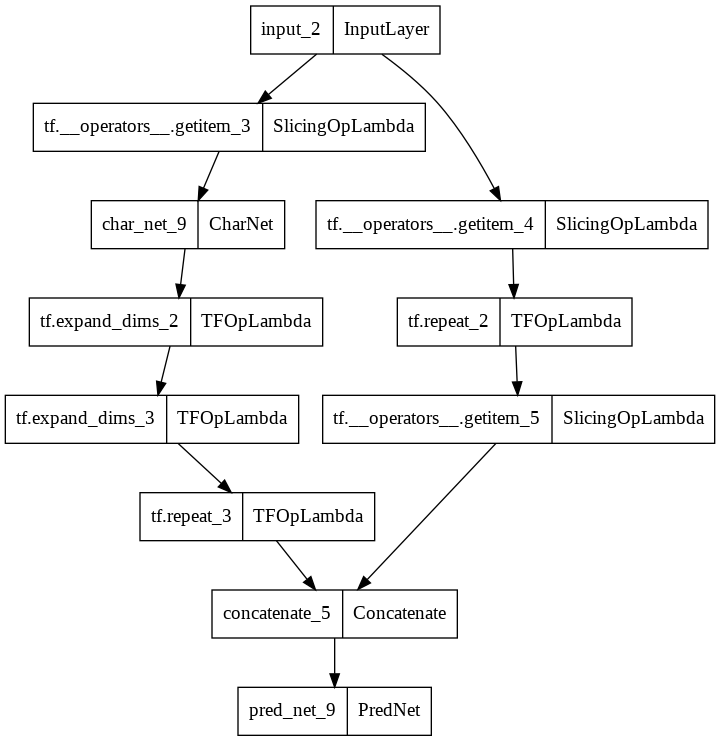

In [100]:
tf.keras.utils.plot_model(ToMnet_N.model())

In [105]:
## Recreate CharNet and PredNet as models to make plotting:
# --------------------------------------------------------------
# CharNet is a layer, as it doesn't have separate and own training,
# it is simply a part of whole network, so can be considered as a layer
# --------------------------------------------------------------
class CharNetModel(Model):

    def __init__(self, input_tensor, n, N_echar):
        super(CharNetModel, self).__init__()

        # self.input_tensor = input_tensor
        self.n = n
        self.N_echar = N_echar

        self.conv = CustomCnnCharNet(input_tensor=input_tensor)
        self.res_blocks = [None] * n
        for i in range(n):
          self.res_blocks[i] = ResBlockCharNet()
        # Global Pool
        self.lstm = CustomLSTM()
        self.e_char = Dense(N_echar)
        

    def call(self, inputs):
        """
        Build the character net.
        """

        # input_tensor = self.input_tensor
        n = self.n
        N_echar = self.N_echar

        batch_size, trajectory_size, height, width, depth  = inputs.get_shape().as_list()

        # --------------------------------------------------------------
        # Paper codes
        # (16, 10, 12, 12, 11) -> (16, 10, 12, 12, 32)
        # Add initial Conv2D layer
        # Conv2D standard: Shape = (batch_size, width, height, channels)
        # Conv2D takes only width x height x channels (12, 12, 11)
        # Time Distributed layer feeds a Conv2D with time-frames (10 frames)
        # That process is happening in parallel for 16 objects in one batch
        # --------------------------------------------------------------
        x = self.conv(inputs)

        # --------------------------------------------------------------
        # Paper codes
        # (16, 10, 12, 12, 11) -> (16, 10, 12, 12, 32)
        # Add n residual layers
        # Conv2D takes only width x height x channels (12, 12, 11)
        # Time Distributed layer feeds a Conv2D with time-frames (10 frames)
        # That process is happening in parallel for 16 objects in one batch
        # --------------------------------------------------------------
        for i in range(n):
          x = self.res_blocks[i](x)    ### Possible error here!!!
            
        # --------------------------------------------------------------
        # Paper codes
        # (16, 10, 12, 12, 32) ->  (16, 10, 32)
        # Add average pooling
        # Collapse the spatial dimensions
        # --------------------------------------------------------------
        x = tf.reduce_mean(input_tensor=x, axis=[2, 3])

        # --------------------------------------------------------------
        # Paper codes
        # (16, 10, 32) ->  (16, 64)
        # Add LSTM
        # Standard: Shape = (batch_size, time_step, features)
        # for each x_i(t)(example_i's step_t): a (64, 1) = W(64, 32) * x (32, 1)
        # --------------------------------------------------------------
        x = self.lstm(x)

        # --------------------------------------------------------------
        # Paper codes
        # (16, 64) -> (16, 4)
        # Add Fully connected layer
        # (batch_size, features) - > (batch_size, e_char)
        # --------------------------------------------------------------
        x = self.e_char(x)

        return x

    ### This is a trick to view shapes in summary() via
    ### model.model().summary()
    def model(self):
        x = tf.keras.Input(shape=(11, 12, 12, 11))
        return tf.keras.Model(inputs=[x], outputs=self.call(x))


In [106]:
CharNet = CharNetModel((10, 12, 12, 11), 5, 8)

In [110]:
CharNet.build((16, 10, 12, 12, 11))

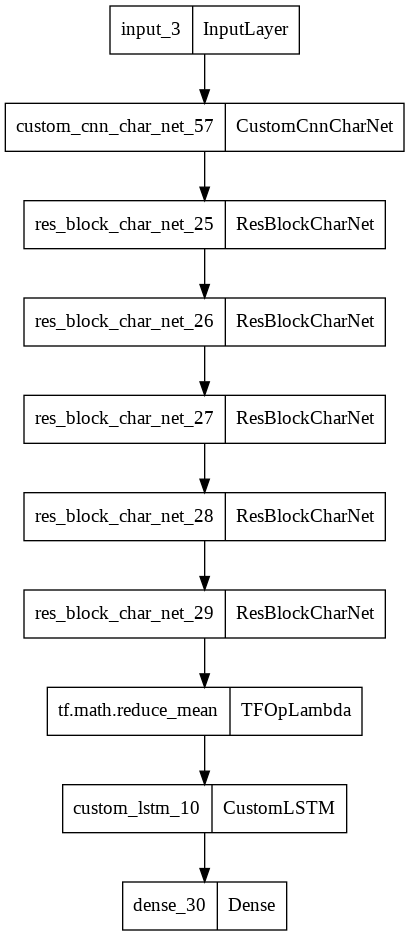

In [112]:
tf.keras.utils.plot_model(CharNet.model())

In [132]:
# --------------------------------------------------------------
# PredNet is a layer, as it doesn't have separate and own training,
# it is simply a part of whole network, so can be considered as a layer
# --------------------------------------------------------------
class PredNetModel(Model):

    def __init__(self, n):
        super(PredNetModel, self).__init__()
        self.n = n

        self.e_char_shape = 8
        self.current_state_shape = (12, 12, 6)

        self.conv_1 = CustomCnnPredNet(input_tensor=self.current_state_shape)
        self.res_blocks = [None] * n
        for i in range(n):
          self.res_blocks[i] = ResBlockPredNet()
        self.conv_2 = CustomCnnPredNet(activation='relu')
        self.fc = Dense(units=60, activation=activations.relu)
        # drop_out_1 = Dropout(rate = 0.2) ### Could be added in the future
        self.goal_predict = Dense(units=4, activation=activations.linear)

    def call(self, inputs):
        """
        Build the character net.
        """
        ### Check that inputs.shape == (None, 13, 12, 8)

        # Get shapes
        # batch_size, height, width, depth = inputs.get_shape().as_list()
        # _, embedding_length = e_char.get_shape().as_list()
        n = self.n

        # --------------------------------------------------------------
        # Paper codes
        # (16, 13, 12, 8) -> (16, 12, 12, 6) + (16, 8)
        # Decompose input data
        # Initially in is a mix of Current State and e_char embedding space
        # --------------------------------------------------------------
        input_current_state = inputs[..., 0:12, 0:12, 0:6]
        e_char = inputs[..., 12, 0, :]

        print("Original Input: ", inputs.shape)
        print("input_current_state: ", input_current_state.shape)
        print("e_char: ", e_char.shape)

        # --------------------------------------------------------------
        # Paper codes
        # (16, 12, 12, 6) -> (16, 12, 12, 32)
        # Use 3x3 conv layer to shape the depth to 32
        # to enable resnet to work (addition between main path and residual connection)
        # --------------------------------------------------------------
        x = self.conv_1(input_current_state)

        # --------------------------------------------------------------
        # Paper codes
        # (16, 12, 12, 32) -> (16, 12, 12, 32)
        # Add n residual layers
        # Conv2D takes only width x height x channels (12, 12, 11)
        # Time Distributed layer feeds a Conv2D with time-frames (10 frames)
        # That process is happening in parallel for 16 objects in one batch
        # --------------------------------------------------------------
        for i in range(n):
          x = self.res_blocks[i](x)    ### Possible error here!!!

        # --------------------------------------------------------------
        # Paper codes
        # (16, 12, 12, 32) -> (16, 12, 12, 32)
        # Add CNN after Res Blocks
        # --------------------------------------------------------------
        x = self.conv_2(x)

        # --------------------------------------------------------------
        # Paper codes
        # (16, 12, 12, 32) -> (16, 32)
        # Add average pooling
        # Collapse the spatial dimensions
        # --------------------------------------------------------------
        x = tf.reduce_mean(input_tensor=x, axis=[1, 2])

        # --------------------------------------------------------------
        # Paper codes
        # (16, 32) + (16, 8) -> (16, 32, 1) + (16, 8, 1) - > 
        # (16, 40, 1) -> (16, 40)
        # Concatenate tensor with e_char
        # Concatenation requires a common dimentions which cannot be a batch
        # --------------------------------------------------------------
        x = tf.expand_dims(x, axis=-1)
        e_char = tf.expand_dims(e_char, axis=-1)

        x = tf.keras.layers.Concatenate(axis=1)([x, e_char])
        x = x[..., 0]

        # --------------------------------------------------------------
        # Paper codes
        # (16, 40) -> (16, 60) -> (16, 4)
        # Fully connected layer with dropout for regularization
        # --------------------------------------------------------------
        x = self.fc(x)
        x =  self.goal_predict(x)

        return x

    ### This is a trick to view shapes in summary() via
    ### model.model().summary()
    def model(self):
        x = tf.keras.Input(shape=(13, 12, 8))
        return tf.keras.Model(inputs=[x], outputs=self.call(x))

In [133]:
PredNetm = PredNetModel(5)
dummy_data = tf.ones((16, 13, 12, 8))
PredNetm.predict(dummy_data)

Original Input:  (None, 13, 12, 8)
input_current_state:  (None, 12, 12, 6)
e_char:  (None, 8)
Original Input:  (None, 13, 12, 8)
input_current_state:  (None, 12, 12, 6)
e_char:  (None, 8)


array([[-0.31517756, -0.02794974, -0.34205836,  1.5141327 ],
       [-0.31517756, -0.02794974, -0.34205836,  1.5141327 ],
       [-0.31517756, -0.02794974, -0.34205836,  1.5141327 ],
       [-0.31517756, -0.02794974, -0.34205836,  1.5141327 ],
       [-0.31517756, -0.02794974, -0.34205836,  1.5141327 ],
       [-0.31517756, -0.02794974, -0.34205836,  1.5141327 ],
       [-0.31517756, -0.02794974, -0.34205836,  1.5141327 ],
       [-0.31517756, -0.02794974, -0.34205836,  1.5141327 ],
       [-0.31517756, -0.02794974, -0.34205836,  1.5141327 ],
       [-0.31517756, -0.02794974, -0.34205836,  1.5141327 ],
       [-0.31517756, -0.02794974, -0.34205836,  1.5141327 ],
       [-0.31517756, -0.02794974, -0.34205836,  1.5141327 ],
       [-0.31517756, -0.02794974, -0.34205836,  1.5141327 ],
       [-0.31517756, -0.02794974, -0.34205836,  1.5141327 ],
       [-0.31517756, -0.02794974, -0.34205836,  1.5141327 ],
       [-0.31517756, -0.02794974, -0.34205836,  1.5141327 ]],
      dtype=float32)

Original Input:  (None, 13, 12, 8)
input_current_state:  (None, 12, 12, 6)
e_char:  (None, 8)


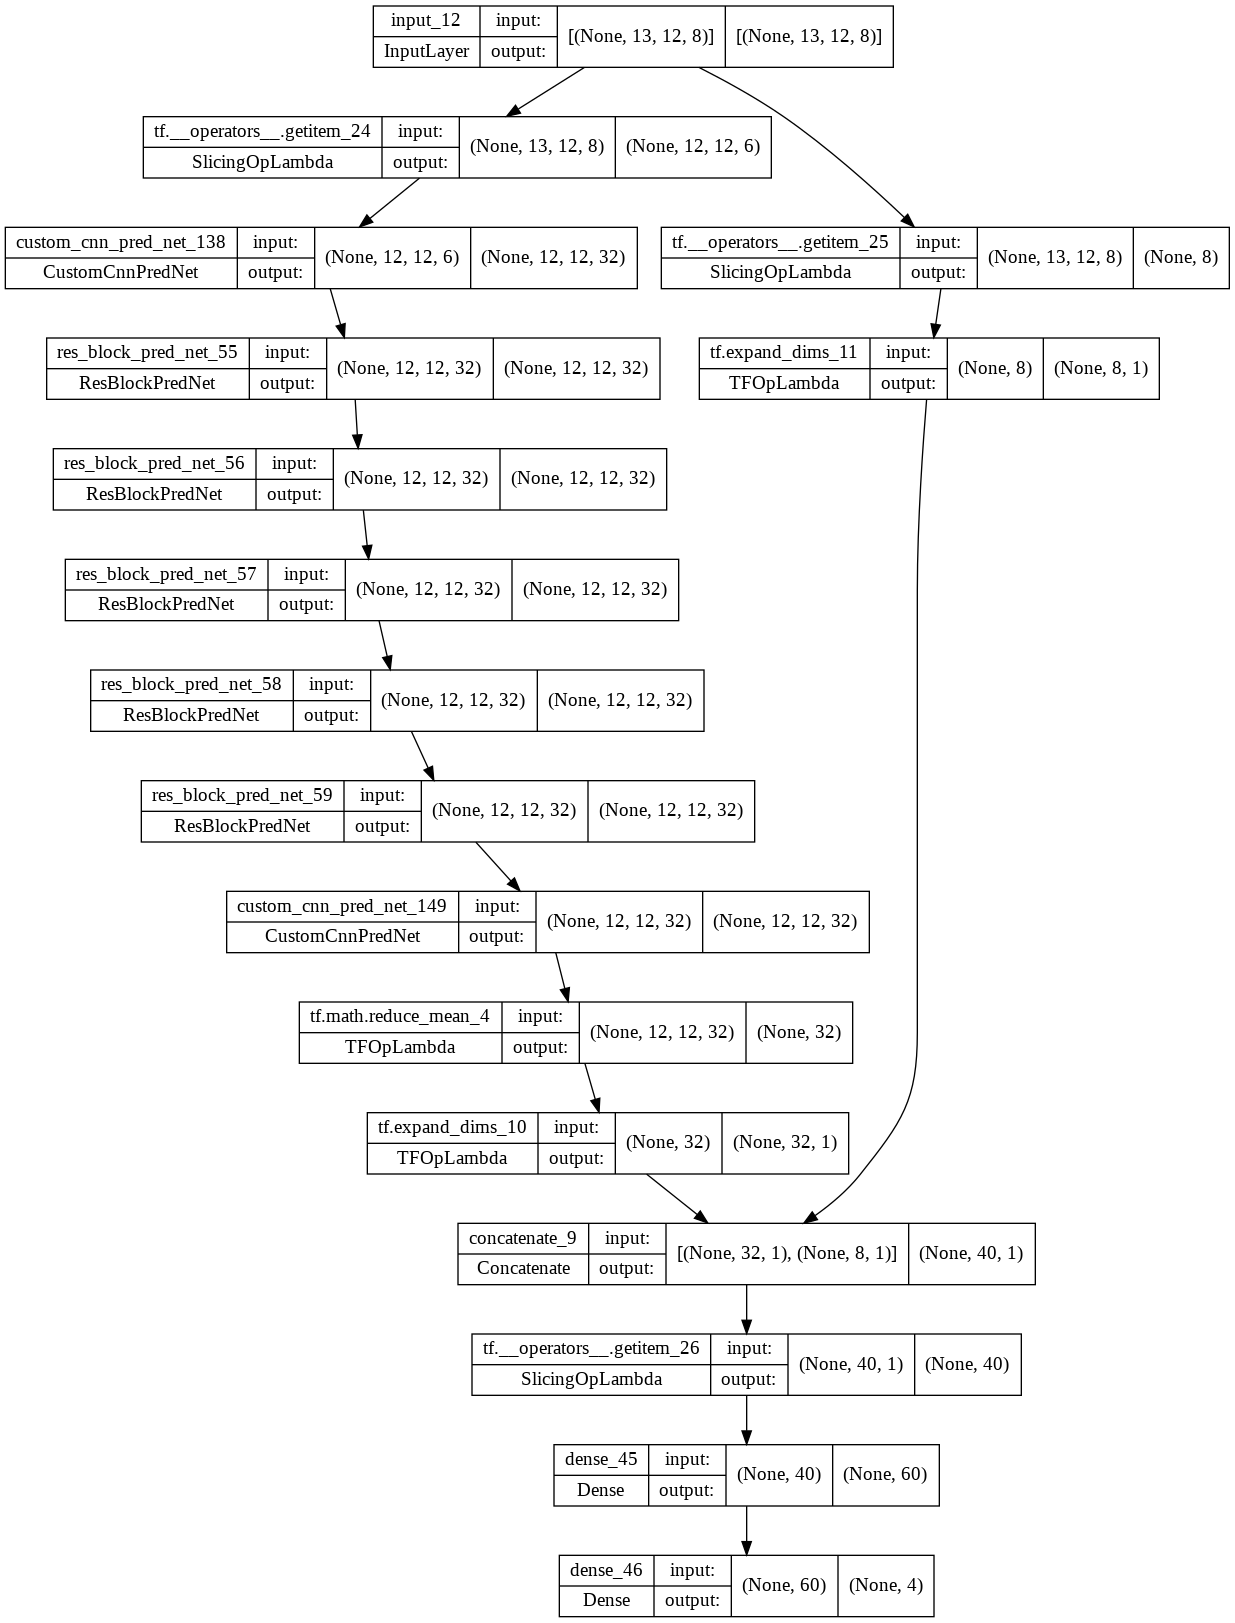

In [136]:
tf.keras.utils.plot_model(PredNetm.model(), show_shapes=True)

In [ ]:
input_trajectory = dummy_combined[0:10,:,:,:]
input_current_state = dummy_combined[10,:,:,0:6]

print("input_trajectory: ", input_trajectory.shape)
print("input_current_state: ", input_current_state.shape)

input_trajectory:  (10, 12, 12, 11)
input_current_state:  (12, 12, 6)


In [ ]:
print(dummy_combined.shape)

(11, 12, 12, 11)


In [ ]:
e_char = tf.ones((8))
dummy_data_2 = tf.ones((12, 12, 6))

e_char_2 =  tf.expand_dims(e_char, axis=0)
e_char_2 =  tf.expand_dims(e_char_2, axis=0)
e_char_2 = tf.repeat(e_char_2, repeats=12, axis=1)

dummy_data_2 = tf.repeat(dummy_data_2, repeats=2, axis=-1)
dummy_data_2 = dummy_data_2[..., 0:8]

mix_data = tf.keras.layers.Concatenate(axis=0)([e_char_2, dummy_data_2])

print("dummy_data_2: ", dummy_data_2.shape)
print("e_char: ", e_char.shape)
print("e_char_2: ", e_char_2.shape)
print("mix_data: ", mix_data.shape)

dummy_data_2:  (12, 12, 8)
e_char:  (8,)
e_char_2:  (1, 12, 8)
mix_data:  (13, 12, 8)


In [ ]:
e_char = mix_data[12,0,:]
input_current_state = mix_data[0:12,:,0:6]

print(e_char.shape)
print(input_current_state.shape)

(8,)
(12, 12, 6)
